# How to Train Relational Fusion Network and Basline Algorithms
-- From original notebook

This notebook gives a brief overview on how to define and train Relational Fusion Networks (RFNs) [1]. You may find an extended arXiv preprint of the paper [here](https://arxiv.org/abs/1908.11567).

The implementation relies on the deep learning framework [MXNet](https://mxnet.incubator.apache.org/), but familiarity with other deep learning frameworks should be sufficient to understand this tutorial. If you are not familiar with any deep learning framework, consider reading [MXNet's tutorial]](https://beta.mxnet.io/guide/crash-course/index.html) on their Gluon API which is used in this library.

-- 

For baseline models, deep graph library with PyTorch backend was used.

In [1]:
%load_ext autoreload
%autoreload 2

### Train
First, define train city sets.

In [2]:
train_cities = ["busan", "daejeon", "goyang", "gwangju", "incheon", "changwon", "seongnam", "cheongju"]
# test_cities = ["daegu", "suwon", "ulsan", "yongin"]

Then define models to train. We used 4 RFN vaiations and 4 baseline models(GAT, GCB, GraphSAGE and MLP).

In [3]:
from custom.rfn_trainer import RFNTrainer
from custom.gcn_trainer import GCNTrainer
from custom.mlp_trainer import MLPTrainer

# RFN models
rfn_trainer_ia = RFNTrainer(fusion='interactional', aggregator='attentional')
rfn_trainer_in = RFNTrainer(fusion='interactional', aggregator='non-attentional')
rfn_trainer_aa = RFNTrainer(fusion='additive', aggregator='attentional')
rfn_trainer_an = RFNTrainer(fusion='additive', aggregator='non-attentional')

# Baseline models
gcn_trainer_gat = GCNTrainer("gat")
gcn_trainer_gcn = GCNTrainer("gcn")
gcn_trainer_gsg = GCNTrainer("graphsage")
mlp_trainer = MLPTrainer()


rfn_models = [rfn_trainer_ia, rfn_trainer_in, rfn_trainer_aa, rfn_trainer_an]
baseline_models = [gcn_trainer_gat, gcn_trainer_gcn, gcn_trainer_gsg, mlp_trainer]
train_models = rfn_models + baseline_models

Using backend: pytorch


Add city information to trainer. Note that MXNet is used for RFN while dgl+PyTorch is used for the rest.

In [5]:
for city_name in train_cities:
    G = load_city_graph(city_name)
    rfn_city, dgl_city = generate_required_city_graph(city_name, G)
    for t in train_models:
        if isinstance(t, RFNTrainer):
            t.add_city(rfn_city)
        else:
            t.add_city(dgl_city)

[47239, 38834, 59559, 38131]
Primal V,E: (20423, 58653), Dual V,E: (58653, 183763)
[33598, 28706, 44151, 28134]
Primal V,E: (14902, 42957), Dual V,E: (42957, 134589)
[11251, 8704, 14834, 8611]
Primal V,E: (5017, 14102), Dual V,E: (14102, 43400)
[28775, 24129, 36772, 23613]
Primal V,E: (12819, 36518), Dual V,E: (36518, 113289)
[25246, 20475, 32989, 20384]
Primal V,E: (12013, 32772), Dual V,E: (32772, 99094)
[22685, 19194, 29090, 18973]
Primal V,E: (9832, 28593), Dual V,E: (28593, 89942)
[9665, 7814, 12507, 7615]
Primal V,E: (4485, 12419), Dual V,E: (12419, 37601)
[25114, 19745, 33108, 19669]
Primal V,E: (11648, 32128), Dual V,E: (32128, 97636)


Train each model 100 times.

In [8]:
train_results = {}
for t in train_models:
    print(t.name)
    t.build()
    train_results[t.name] = t.train(100, verbose=False)

rfn_int_att
FeatureInfo(no_node_features=2, no_edge_features=16, no_between_edge_features=4)
Training Started for RFN
rfn_int_non
FeatureInfo(no_node_features=2, no_edge_features=16, no_between_edge_features=4)
Training Started for RFN
rfn_add_att
FeatureInfo(no_node_features=2, no_edge_features=16, no_between_edge_features=4)
Training Started for RFN
rfn_add_non
FeatureInfo(no_node_features=2, no_edge_features=16, no_between_edge_features=4)
Training Started for RFN
gat


/opt/conda/conda-bld/pytorch_1587428266983/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


gcn
graphsage
mlp


Let's plot train log with exponential weighted moving average.

In [23]:
train_results_ewma = pd.DataFrame.from_dict(train_results)
train_results_ewma = results_pd.ewm(span=8).mean()

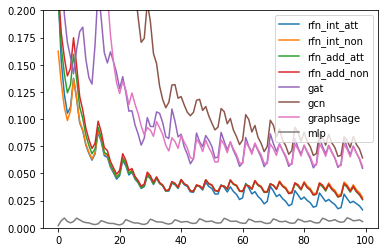

In [24]:
import matplotlib.pyplot as plt
L = len(list(train_results.values())[0])
for t in train_models:
    plt.plot([i for i in range(L)], train_results_ewma[t.name], label=t.name)
plt.legend()
plt.ylim((0.0, 0.2))
plt.show()

Finally export model data.

In [28]:
import datetime
import os
datetimename = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
os.mkdir("model_data/%s" % datetimename)
for t in train_models:
    t.save_params("model_data/%s/%s" % (datetimename, t.name))

## References
[1]: Tobias Skovgaard Jepsen, Christian S. Jensen, and Thomas Dyhre Nielsen.  "Graph Convolutional Networks for Road Networks." In _27th ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems (SIGSPATIAL ’19)_. 2019.

[2]: Tobias Skovgaard Jepsen, Christian S. Jensen, and Thomas Dyhre Nielsen. "Graph Convolutional Networks for Road Networks." _arXiv e-prints_, arXiv:1908.11567. 2019.

[3]: Hamilton, Will, Zhitao Ying, and Jure Leskovec. "Inductive representation learning on large graphs." _Advances in Neural Information Processing Systems_. 2017.